In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import gc

gc.collect()

torch.cuda.empty_cache()


In [ ]:
!nvidia-smi

In [1]:
from transformers import BlipProcessor, BlipForQuestionAnswering, BlipForConditionalGeneration
import torch

model_id = "Salesforce/blip-vqa-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained(model_id)
processor.tokenizer.padding_side = "left"
model = BlipForQuestionAnswering.from_pretrained(model_id)

2025-05-18 03:40:19.126991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747539619.371396      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747539619.443487      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [2]:
!mkdir extracted_abo_images/
!tar -xJf "/kaggle/input/image-dataset/abo-images-small.tar.xz" -C "extracted_abo_images/"

In [3]:
# ---- Configuration ----
CSV_FOLDER = "extracted_abo_images/abo-images-small/images/dataset_csv"
IMAGE_DIR = "extracted_abo_images/abo-images-small/images/small"
MODEL_NAME = "Salesforce/blip-vqa-base"
BATCH_SIZE = 8
NUM_EPOCHS = 1
LEARNING_RATE = 5e-5
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import pandas as pd
import os

df = pd.concat([
    pd.read_csv(os.path.join(CSV_FOLDER, f))
    for f in os.listdir(CSV_FOLDER) if f.endswith(".csv")
])

print(f"Loaded {len(df)} rows from CSVs")
df = df[df['answer'].notnull()]
df = df[df['image_id'].notnull()]
df = df[df['path'].notnull()]
df = df[df['question'].notnull()]
print(f"New {len(df)} rows from CSVs")

Loaded 80336 rows from CSVs
New 79990 rows from CSVs


In [5]:
from sklearn.model_selection import train_test_split

y = df['answer']
X = df.drop('answer',axis=1)
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(
  X,y , random_state=104,test_size=0.25, shuffle=True)

In [6]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [7]:
train_df.head()

,image_id,path,question,answer
2984,61iaE3Nsc6L,42/425a17ba.jpg,What part is slightly raised?,Bezel
2314,8108si1j8yL,02/02e2f54d.jpg,What feature lifts the screen?,Bezel
2094,51sCmvSLL7L,68/68f0f043.jpg,What size bolts are mentioned?,M8-32
545,81CCBDZGImL,5f/5f386236.jpg,What is the jewelry's primary metal color?,Silver
7307,71XQetonYTL,2b/2b255877.jpg,What type of lock does the luggage have?,TSA


In [8]:
print(len(train_df))

59992


In [14]:
from torch.utils.data import Dataset
from PIL import Image

class VQADataset(Dataset):
    def __init__(self, df, image_dir, processor):
        self.data = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['path'])
        image = Image.open(image_path).convert("RGB")
        # prompt = "You are an expert image QA assistant. Answer the following question."
        prompt = ""
        question = str(prompt + "Question:" + row["question"])
        answer = str(row["answer"])

        inputs = self.processor(images=image, text=question, return_tensors="pt", padding='max_length', max_length=32, truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = processor.tokenizer(answer, return_tensors="pt", padding='max_length', max_length=5, truncation=True).input_ids.squeeze(0)
        return inputs

In [15]:
def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    input_ids = torch.nn.utils.rnn.pad_sequence(
        [x["input_ids"] for x in batch], batch_first=True, padding_value=processor.tokenizer.pad_token_id
    )
    attention_mask = torch.nn.utils.rnn.pad_sequence(
        [x["attention_mask"] for x in batch], batch_first=True, padding_value=0
    )
    labels = torch.nn.utils.rnn.pad_sequence(
        [x["labels"] for x in batch], batch_first=True, padding_value=-100
    )
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [16]:
from torch.utils.data import DataLoader

train_dataset = VQADataset(train_df[:8000], IMAGE_DIR, processor)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
)

In [24]:
from peft import get_peft_model, LoraConfig, TaskType
import inspect
import types

# Wrap with LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.01,
    bias="none",
    task_type="CAUSAL_LM",  # ✅ use correct task
)
lora_model = get_peft_model(model, lora_config)

# 1. Get original method
_orig_forward = BlipForQuestionAnswering.forward

# 2. Allowed kwargs from the method signature
_allowed = set(inspect.signature(_orig_forward).parameters.keys())

# 3. Define patched forward
def _patched_forward(self, *args, **kwargs):
    filtered_kwargs = {k: v for k, v in kwargs.items() if k in _allowed}
    return _orig_forward(self, *args, **filtered_kwargs)

# 4. Bind patched method to instance
lora_model.base_model.forward = types.MethodType(_patched_forward, lora_model.base_model)

# Send to device
device = "cuda" if torch.cuda.is_available() else "cpu"
lora_model.to(device)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BlipForQuestionAnswering(
      (vision_model): BlipVisionModel(
        (embeddings): BlipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (encoder): BlipEncoder(
          (layers): ModuleList(
            (0-11): 12 x BlipEncoderLayer(
              (self_attn): BlipAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear(in_features=768, out_features=2304, bias=True)
                (projection): Linear(in_features=768, out_features=768, bias=True)
              )
              (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): BlipMLP(
                (activation_fn): GELUActivation()
                (fc1): Linear(in_features=768, out_features=3072, bias=True)
                (fc2): Linear(in_features=3072, out_features=768, bias=True)
              )
              (layer_

In [27]:
# ─── 3) Dataloader, Optimizer ─────────────────────────────────────────────────


optimizer = torch.optim.AdamW(lora_model.parameters(), lr=3e-5)


# ─── 4) Training Loop with Manual Loss ────────────────────────────────────────

NUM_EPOCHS = 1

for epoch in range(NUM_EPOCHS):
    lora_model.train()
    print(len(train_dataloader))
    batch_no = 0
    for batch in train_dataloader:
        # move tensors to device
        pixel_values   = batch["pixel_values"]
        input_ids      = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels         = batch["labels"]    # (B, L), pads = -100

        
        # forward *without* passing labels to avoid built-in loss
        outputs = lora_model(
            pixel_values=pixel_values.to(device),
            input_ids=input_ids.to(device),
            attention_mask=attention_mask.to(device),
            labels=labels.to(device),
            return_dict=True,
        )


        
        loss = outputs.loss
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"[Epoch {epoch+1}] loss: {loss.item():.4f} batch: {batch_no}")
        batch_no += 1

print("Training complete!")

NameError: name 'lora_model' is not defined

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_dataloader) * NUM_EPOCHS
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, warmup_steps, total_steps
)
lora_model.to(device)
for epoch in range(NUM_EPOCHS):
    lora_model.train()
    for batch_no, batch in enumerate(train_dataloader):
        # unpack + move to device
        pixel_values   = batch["pixel_values"].to(device)
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        # print("input_ids shape:", batch["input_ids"].shape)
        # print("labels shape:", batch["labels"].shape)
        # forward + loss
        outputs = lora_model(
            pixel_values   = pixel_values,
            input_ids      = input_ids,
            attention_mask = attention_mask,
            labels         = labels
        )
        loss = outputs.loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(f"[E{epoch+1} B{batch_no}] loss={loss.item():.4f}")

        # if batch_no % 10 == 0:
        #     with torch.no_grad():
        #         gen_ids = model.generate(
        #             pixel_values   = pixel_values,
        #             input_ids      = input_ids,
        #             attention_mask = attention_mask
        #         )
        
        #     print(f"[E{epoch+1} B{batch_no}] loss={loss.item():.4f}")
        
        #     for i in range(pixel_values.size(0)):  # Iterate over the batch
        #         # Prepare the gold label
        #         lbl = labels[i].clone()
        #         lbl[lbl == -100] = processor.tokenizer.pad_token_id
        
        #         question = processor.tokenizer.decode(input_ids[i], skip_special_tokens=True)
        #         gold     = processor.tokenizer.decode(lbl, skip_special_tokens=True)
        #         gen      = processor.tokenizer.decode(gen_ids[i], skip_special_tokens=True)
        
        #         print(f"\nSample #{i+1}")
        #         print("Q:   ", question)
        #         print("Gold:", gold)
        #         print("Gen: ", gen)


In [26]:
# BASE_MODEL_DIR = "base_model"
OUTPUT_DIR_MODEL = "fine_tuned_blip_lora"
OUTPUT_DIR_PROCESSOR = "fine_tuned_blip_lora_processor"

# base_model.save_pretrained(BASE_MODEL_DIR)
# 1) Save the full model + adapters
lora_model.save_pretrained(OUTPUT_DIR_MODEL)
processor.save_pretrained(OUTPUT_DIR_PROCESSOR)

[]

In [ ]:
# === Prepare test dataloader ===
test_dataset = VQADataset(test_df[:1024], IMAGE_DIR, processor)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# === Inference loop to generate predictions ===
from PIL import Image
from tqdm import tqdm

predictions = []
references = []

lora_model.eval()
for i, row in tqdm(test_df[:1024].iterrows(), total=len(test_df[:1024]), desc="Generating Predictions"):
    image_path = os.path.join(IMAGE_DIR, row["path"])
    question = row["question"]
    answer = row["answer"]

    image = Image.open(image_path).convert("RGB")
    inputs = processor(
        image,
        question,
        return_tensors="pt",
        padding=True, truncation=True, max_length=32
    ).to(device)

    with torch.no_grad():
        generated_ids = lora_model.generate(**inputs)

    decoded = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(f"answer={answer}")
    print(f"decoded={decoded}")
    predictions.append(decoded)
    references.append(answer)


In [28]:
!pip install bert-score


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [19]:
!pip install bert-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [20]:
from bert_score import score as bert_score

predictions = [str(x) for x in predictions]
references = [str(x) for x in references]


P, R, F1 = bert_score(
    cands=predictions,
    refs=references,
    lang="en",
    rescale_with_baseline=True
)

print(f"\n🔍 BERTScore:")
print(f" - Precision: {P.mean():.4f}")
print(f" - Recall:    {R.mean():.4f}")
print(f" - F1 Score:  {F1.mean():.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔍 BERTScore:
 - Precision: 0.6344
 - Recall:    0.5458
 - F1 Score:  0.5841


# BASELINE EVALUATION

In [17]:
from transformers import BlipProcessor, BlipForQuestionAnswering, BlipForConditionalGeneration
import torch

model_id = "Salesforce/blip-vqa-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained(model_id)
processor.tokenizer.padding_side = "left"
model = BlipForQuestionAnswering.from_pretrained(model_id)
model.to(device)
# === Prepare test dataloader ===
test_dataset = VQADataset(test_df[:1024], IMAGE_DIR, processor)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# === Inference loop to generate predictions ===
from PIL import Image
from tqdm import tqdm

predictions = []
references = []

model.eval()
for i, row in tqdm(test_df[:1024].iterrows(), total=len(test_df[:1024]), desc="Generating Predictions"):
    image_path = os.path.join(IMAGE_DIR, row["path"])
    question = row["question"]
    answer = row["answer"]

    image = Image.open(image_path).convert("RGB")
    inputs = processor(
        image,
        question,
        return_tensors="pt",
        padding=True, truncation=True, max_length=32
    ).to(device)

    with torch.no_grad():
        generated_ids = model.generate(**inputs)

    decoded = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    predictions.append(decoded)
    references.append(answer)

from bert_score import score as bert_score



Generating Predictions: 100%|██████████| 1024/1024 [01:27<00:00, 11.66it/s]


ModuleNotFoundError: No module named 'bert_score'

In [21]:
from bert_score import score as bert_score

predictions = [str(x) for x in predictions]
references = [str(x) for x in references]


P, R, F1 = bert_score(
    cands=predictions,
    refs=references,
    lang="en",
    rescale_with_baseline=True
)

print(f"\n🔍 BERTScore:")
print(f" - Precision: {P.mean():.4f}")
print(f" - Recall:    {R.mean():.4f}")
print(f" - F1 Score:  {F1.mean():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔍 BERTScore:
 - Precision: 0.6344
 - Recall:    0.5458
 - F1 Score:  0.5841


In [30]:
import shutil

# Replace 'my_folder' with your actual folder name
shutil.make_archive('PROCESSOR', 'zip', '/kaggle/working/fine_tuned_blip_lora_processor')
shutil.make_archive('MODEL', 'zip', '/kaggle/working/fine_tuned_blip_lora')

'/kaggle/working/MODEL.zip'

In [22]:
def exact_match(preds, refs):
    return sum(p.strip().lower() == r.strip().lower() for p, r in zip(preds, refs)) / len(preds)

em_score = exact_match(predictions, references)
print(f"✅ Exact Match Accuracy: {em_score:.4f}")


✅ Exact Match Accuracy: 0.2227


In [23]:
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [24]:
from nltk.corpus import wordnet as wn

def wup_similarity(word1, word2):
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)
    if not synsets1 or not synsets2:
        return 0
    max_sim = max((s1.wup_similarity(s2) or 0) for s1 in synsets1 for s2 in synsets2)
    return max_sim

def compute_wups(preds, refs, threshold=0.9):
    total_score = 0
    for pred, ref in zip(preds, refs):
        pred_words = pred.lower().split()
        ref_words = ref.lower().split()
        score = 0
        for pw in pred_words:
            max_sim = max((wup_similarity(pw, rw) for rw in ref_words), default=0)
            score += 1 if max_sim >= threshold else max_sim
        score /= len(pred_words)
        total_score += score
    return total_score / len(preds)

wups_0 = compute_wups(predictions, references, threshold=0.0)
wups_9 = compute_wups(predictions, references, threshold=0.9)

print(f"🔄 WUPS @ 0.0 (lenient): {wups_0:.4f}")
print(f"🔒 WUPS @ 0.9 (strict):  {wups_9:.4f}")


🔄 WUPS @ 0.0 (lenient): 1.0000
🔒 WUPS @ 0.9 (strict):  0.5978


In [25]:
final_wups = 0.1 * wups_0 + 0.9 * wups_9
print(f"🏁 Final Weighted WUPS Score: {final_wups:.4f}")


🏁 Final Weighted WUPS Score: 0.6380


In [27]:
!pip install sentence-transformers
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [28]:
from sentence_transformers import SentenceTransformer
from evaluate import load
import numpy as np

sbert = SentenceTransformer('all-MiniLM-L6-v2')
meteor = load("meteor")

# SBERT cosine similarity
emb_pred = sbert.encode(predictions, convert_to_tensor=True)
emb_ref  = sbert.encode(references, convert_to_tensor=True)
cos_sim = (emb_pred * emb_ref).sum(dim=1) / (emb_pred.norm(dim=1) * emb_ref.norm(dim=1))

sbert_score = cos_sim.mean().item()
print(f"💠 SBERT Similarity Score: {sbert_score:.4f}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

💠 SBERT Similarity Score: 0.5578


In [29]:
meteor_score = meteor.compute(predictions=predictions, references=references)["meteor"]
print(f"🌠 METEOR Score: {meteor_score:.4f}")


🌠 METEOR Score: 0.1373


# FINE-TUNED LORA

In [56]:
OUTPUT_DIR_MODEL = "/kaggle/input/fine_tuned_blip_lora/pytorch/default/1/MODEL"
OUTPUT_DIR_PROCESSOR = "/kaggle/input/fine_tuned_blip_lora/pytorch/default/1/PROCESSOR"

In [57]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from peft import PeftModel
import inspect
import types

processor = BlipProcessor.from_pretrained(OUTPUT_DIR_PROCESSOR)
device = "cuda" if torch.cuda.is_available() else "cpu"
# load base model then inject adapters
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)
lora_model = PeftModel.from_pretrained(model, OUTPUT_DIR_MODEL)


# 1) Grab the unbound original forward from the class
_orig_bmf = BlipForQuestionAnswering.forward

# 2) Compute which kwargs the class really accepts
_sig = inspect.signature(_orig_bmf)
_allowed = set(_sig.parameters.keys())

# 3) Define a wrapper that drops anything extra and delegates to the original
def _patched_forward(self, *args, **kwargs):
    # keep only args the original signature names
    filtered_kwargs = {k: v for k, v in kwargs.items() if k in _allowed}
    return _orig_bmf(self, *args, **filtered_kwargs)

# 4) Bind that wrapper onto your instance
lora_model.base_model.forward = types.MethodType(_patched_forward, lora_model.base_model)
lora_model.to(device)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BlipForQuestionAnswering(
      (vision_model): BlipVisionModel(
        (embeddings): BlipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (encoder): BlipEncoder(
          (layers): ModuleList(
            (0-11): 12 x BlipEncoderLayer(
              (self_attn): BlipAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear(in_features=768, out_features=2304, bias=True)
                (projection): Linear(in_features=768, out_features=768, bias=True)
              )
              (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): BlipMLP(
                (activation_fn): GELUActivation()
                (fc1): Linear(in_features=768, out_features=3072, bias=True)
                (fc2): Linear(in_features=3072, out_features=768, bias=True)
              )
              (layer_

In [58]:
# === Inference loop to generate predictions ===
from PIL import Image
from tqdm import tqdm

predictions = []
references = []

lora_model.eval()
for i, row in tqdm(test_df[:1024].iterrows(), total=len(test_df[:1024]), desc="Generating Predictions"):
    image_path = os.path.join(IMAGE_DIR, row["path"])
    question = row["question"]
    answer = row["answer"]

    image = Image.open(image_path).convert("RGB")
    inputs = processor(
        image,
        question,
        return_tensors="pt",
        padding=True, truncation=True, max_length=32
    ).to(device)

    with torch.no_grad():
        generated_ids = lora_model.generate(**inputs)

    decoded = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    predictions.append(decoded)
    references.append(answer)

Generating Predictions: 100%|██████████| 1024/1024 [01:43<00:00,  9.87it/s]


In [59]:
from bert_score import score as bert_score

predictions = [str(x) for x in predictions]
references = [str(x) for x in references]

# Filter out empty predictions or references
cleaned_preds = []
cleaned_refs = []

for pred, ref in zip(predictions, references):
    if pred.strip() != "" and ref.strip() != "":
        cleaned_preds.append(pred)
        cleaned_refs.append(ref)
        
P, R, F1 = bert_score(
    cands=cleaned_preds,
    refs=cleaned_refs,
    lang="en",
    rescale_with_baseline=True
)

print(f"\n🔍 BERTScore:")
print(f" - Precision: {P.mean():.4f}")
print(f" - Recall:    {R.mean():.4f}")
print(f" - F1 Score:  {F1.mean():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔍 BERTScore:
 - Precision: 0.6268
 - Recall:    0.5493
 - F1 Score:  0.5819


In [60]:
def exact_match(preds, refs):
    return sum(p.strip().lower() == r.strip().lower() for p, r in zip(preds, refs)) / len(preds)

em_score = exact_match(cleaned_preds, cleaned_refs)
print(f"✅ Exact Match Accuracy: {em_score:.4f}")


✅ Exact Match Accuracy: 0.2172


In [36]:
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [61]:
from nltk.corpus import wordnet as wn

def wup_similarity(word1, word2):
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)
    if not synsets1 or not synsets2:
        return 0
    max_sim = max((s1.wup_similarity(s2) or 0) for s1 in synsets1 for s2 in synsets2)
    return max_sim

def compute_wups(preds, refs, threshold=0.9):
    total_score = 0
    for pred, ref in zip(preds, refs):
        pred_words = pred.lower().split()
        if len(pred_words) == 0:
            continue
        ref_words = ref.lower().split()
        score = 0
        for pw in pred_words:
            max_sim = max((wup_similarity(pw, rw) for rw in ref_words), default=0)
            score += 1 if max_sim >= threshold else max_sim
        score /= len(pred_words)
        total_score += score
    return total_score / len(preds)

wups_0 = compute_wups(cleaned_preds, cleaned_refs, threshold=0.0)
wups_9 = compute_wups(cleaned_preds, cleaned_refs, threshold=0.9)

print(f"🔄 WUPS @ 0.0 (lenient): {wups_0:.4f}")
print(f"🔒 WUPS @ 0.9 (strict):  {wups_9:.4f}")


🔄 WUPS @ 0.0 (lenient): 1.0000
🔒 WUPS @ 0.9 (strict):  0.5944


In [62]:
final_wups = 0.1 * wups_0 + 0.9 * wups_9
print(f"🏁 Final Weighted WUPS Score: {final_wups:.4f}")


🏁 Final Weighted WUPS Score: 0.6350


In [ ]:
!pip install sentence-transformers
!pip install evaluate

In [63]:
from sentence_transformers import SentenceTransformer
from evaluate import load
import numpy as np

sbert = SentenceTransformer('all-MiniLM-L6-v2')
meteor = load("meteor")

# SBERT cosine similarity
emb_pred = sbert.encode(cleaned_preds, convert_to_tensor=True)
emb_ref  = sbert.encode(cleaned_refs, convert_to_tensor=True)
cos_sim = (emb_pred * emb_ref).sum(dim=1) / (emb_pred.norm(dim=1) * emb_ref.norm(dim=1))

sbert_score = cos_sim.mean().item()
print(f"💠 SBERT Similarity Score: {sbert_score:.4f}")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

💠 SBERT Similarity Score: 0.5567


In [64]:
meteor_score = meteor.compute(predictions=cleaned_preds, references=cleaned_refs)["meteor"]
print(f"🌠 METEOR Score: {meteor_score:.4f}")

🌠 METEOR Score: 0.1342


# MODEL 2

In [65]:
OUTPUT_DIR_MODEL = "/kaggle/input/lora_fine_tune_blip_v2/pytorch/default/1/MODEL"
OUTPUT_DIR_PROCESSOR = "/kaggle/input/lora_fine_tune_blip_v2/pytorch/default/1/PROCESSOR"

In [66]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from peft import PeftModel
import inspect
import types

processor = BlipProcessor.from_pretrained(OUTPUT_DIR_PROCESSOR)
device = "cuda" if torch.cuda.is_available() else "cpu"
# load base model then inject adapters
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)
lora_model = PeftModel.from_pretrained(model, OUTPUT_DIR_MODEL)


# 1) Grab the unbound original forward from the class
_orig_bmf = BlipForQuestionAnswering.forward

# 2) Compute which kwargs the class really accepts
_sig = inspect.signature(_orig_bmf)
_allowed = set(_sig.parameters.keys())

# 3) Define a wrapper that drops anything extra and delegates to the original
def _patched_forward(self, *args, **kwargs):
    # keep only args the original signature names
    filtered_kwargs = {k: v for k, v in kwargs.items() if k in _allowed}
    return _orig_bmf(self, *args, **filtered_kwargs)

# 4) Bind that wrapper onto your instance
lora_model.base_model.forward = types.MethodType(_patched_forward, lora_model.base_model)
lora_model.to(device)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BlipForQuestionAnswering(
      (vision_model): BlipVisionModel(
        (embeddings): BlipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (encoder): BlipEncoder(
          (layers): ModuleList(
            (0-11): 12 x BlipEncoderLayer(
              (self_attn): BlipAttention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear(in_features=768, out_features=2304, bias=True)
                (projection): Linear(in_features=768, out_features=768, bias=True)
              )
              (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): BlipMLP(
                (activation_fn): GELUActivation()
                (fc1): Linear(in_features=768, out_features=3072, bias=True)
                (fc2): Linear(in_features=3072, out_features=768, bias=True)
              )
              (layer_

In [67]:
# === Inference loop to generate predictions ===
from PIL import Image
from tqdm import tqdm

predictions = []
references = []

lora_model.eval()
for i, row in tqdm(test_df[:1024].iterrows(), total=len(test_df[:1024]), desc="Generating Predictions"):
    image_path = os.path.join(IMAGE_DIR, row["path"])
    question = row["question"]
    answer = row["answer"]

    image = Image.open(image_path).convert("RGB")
    inputs = processor(
        image,
        question,
        return_tensors="pt",
        padding=True, truncation=True, max_length=32
    ).to(device)

    with torch.no_grad():
        generated_ids = lora_model.generate(**inputs)

    decoded = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    predictions.append(decoded)
    references.append(answer)

Generating Predictions: 100%|██████████| 1024/1024 [01:43<00:00,  9.89it/s]


In [68]:
from bert_score import score as bert_score

predictions = [str(x) for x in predictions]
references = [str(x) for x in references]

# Filter out empty predictions or references
cleaned_preds = []
cleaned_refs = []

for pred, ref in zip(predictions, references):
    if pred.strip() != "" and ref.strip() != "":
        cleaned_preds.append(pred)
        cleaned_refs.append(ref)

P, R, F1 = bert_score(
    cands=cleaned_preds,
    refs=cleaned_refs,
    lang="en",
    rescale_with_baseline=True
)

print(f"\n🔍 BERTScore:")
print(f" - Precision: {P.mean():.4f}")
print(f" - Recall:    {R.mean():.4f}")
print(f" - F1 Score:  {F1.mean():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔍 BERTScore:
 - Precision: 0.6349
 - Recall:    0.5488
 - F1 Score:  0.5858


In [69]:
def exact_match(preds, refs):
    return sum(p.strip().lower() == r.strip().lower() for p, r in zip(preds, refs)) / len(preds)

em_score = exact_match(cleaned_preds, cleaned_refs)
print(f"✅ Exact Match Accuracy: {em_score:.4f}")


✅ Exact Match Accuracy: 0.2211


In [70]:
from nltk.corpus import wordnet as wn

def wup_similarity(word1, word2):
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)
    if not synsets1 or not synsets2:
        return 0
    max_sim = max((s1.wup_similarity(s2) or 0) for s1 in synsets1 for s2 in synsets2)
    return max_sim

def compute_wups(preds, refs, threshold=0.9):
    total_score = 0
    for pred, ref in zip(preds, refs):
        pred_words = pred.lower().split()
        if len(pred_words) == 0:
            continue
        ref_words = ref.lower().split()
        score = 0
        for pw in pred_words:
            max_sim = max((wup_similarity(pw, rw) for rw in ref_words), default=0)
            score += 1 if max_sim >= threshold else max_sim
        score /= len(pred_words)
        total_score += score
    return total_score / len(preds)

wups_0 = compute_wups(cleaned_preds, cleaned_refs, threshold=0.0)
wups_9 = compute_wups(cleaned_preds, cleaned_refs, threshold=0.9)

print(f"🔄 WUPS @ 0.0 (lenient): {wups_0:.4f}")
print(f"🔒 WUPS @ 0.9 (strict):  {wups_9:.4f}")


🔄 WUPS @ 0.0 (lenient): 1.0000
🔒 WUPS @ 0.9 (strict):  0.5951


In [71]:
final_wups = 0.1 * wups_0 + 0.9 * wups_9
print(f"🏁 Final Weighted WUPS Score: {final_wups:.4f}")


🏁 Final Weighted WUPS Score: 0.6356


In [72]:
from sentence_transformers import SentenceTransformer
from evaluate import load
import numpy as np

sbert = SentenceTransformer('all-MiniLM-L6-v2')
meteor = load("meteor")

# SBERT cosine similarity
emb_pred = sbert.encode(cleaned_preds, convert_to_tensor=True)
emb_ref  = sbert.encode(cleaned_refs, convert_to_tensor=True)
cos_sim = (emb_pred * emb_ref).sum(dim=1) / (emb_pred.norm(dim=1) * emb_ref.norm(dim=1))

sbert_score = cos_sim.mean().item()
print(f"💠 SBERT Similarity Score: {sbert_score:.4f}")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

💠 SBERT Similarity Score: 0.5575


In [73]:
meteor_score = meteor.compute(predictions=cleaned_preds, references=cleaned_refs)["meteor"]
print(f"🌠 METEOR Score: {meteor_score:.4f}")

🌠 METEOR Score: 0.1352


In [ ]:
data1 = {
    'Model': ['CLIP', 'ViLBERT', 'BLIP', 'OFA', 'BLIP-2', 'Qwen2.5-VL', 'SmolVLM'],
    'Parameters': [150, 138, 385, 180, 3900, 3000, 500],
    'Precision': [0.48012, 0.59832, 0.68042, 0.61845, 0.6723, 0.67654, 0.58911],
    'Recall': [0.52044, 0.62743, 0.65671, 0.64178, 0.66325, 0.66183, 0.61042],
    'F1(BERTScore)': [0.49973, 0.61256, 0.66837, 0.62987, 0.66775, 0.66913, 0.59957],
    'BARTScore': [0.39451, 0.54829, 0.62488, 0.58711, 0.62957, 0.63412, 0.54281],
    'SBERT': [0.52133, 0.6311, 0.67544, 0.64309, 0.67894, 0.68122, 0.61278],
    'METEOR': [0.36422, 0.51238, 0.59845, 0.56789, 0.61432, 0.6721, 0.48971],
    'Exact Match': [0.15762, 0.10982, 0.19428, 0.13984, 0.20329, 0.21172, 0.19822],
    'Average_Mark': [0.01153, 0.03732, 0.09371, 0.07872, 0.0995, 0.10941, 0.09109],
    'WUPS (0.0)': [0.63214, 0.74229, 0.81425, 0.76942, 0.81602, 0.81988, 0.73218],
    'WUPS (0.9)': [0.71234, 0.81238, 0.87411, 0.8291, 0.87699, 0.87934, 0.80055],
    'Weighted WUPS': [0.6892, 0.7871, 0.8519, 0.80345, 0.85611, 0.86193, 0.77801]
}

df1 = pd.DataFrame(data1)
with open('all_models_metrics.csv', 'w') as f:
    df1.to_csv(f, index=False)

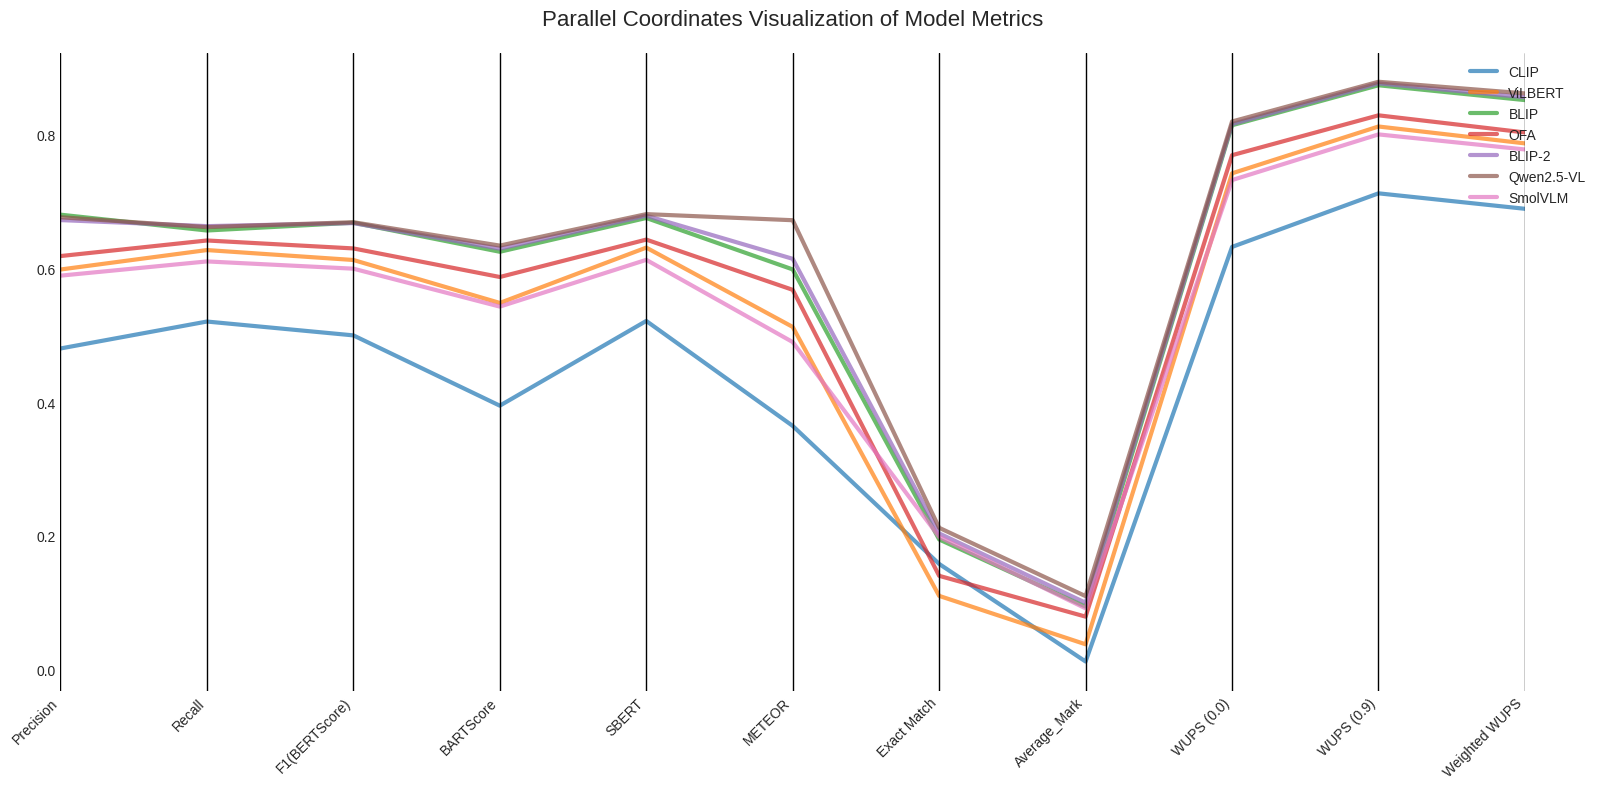

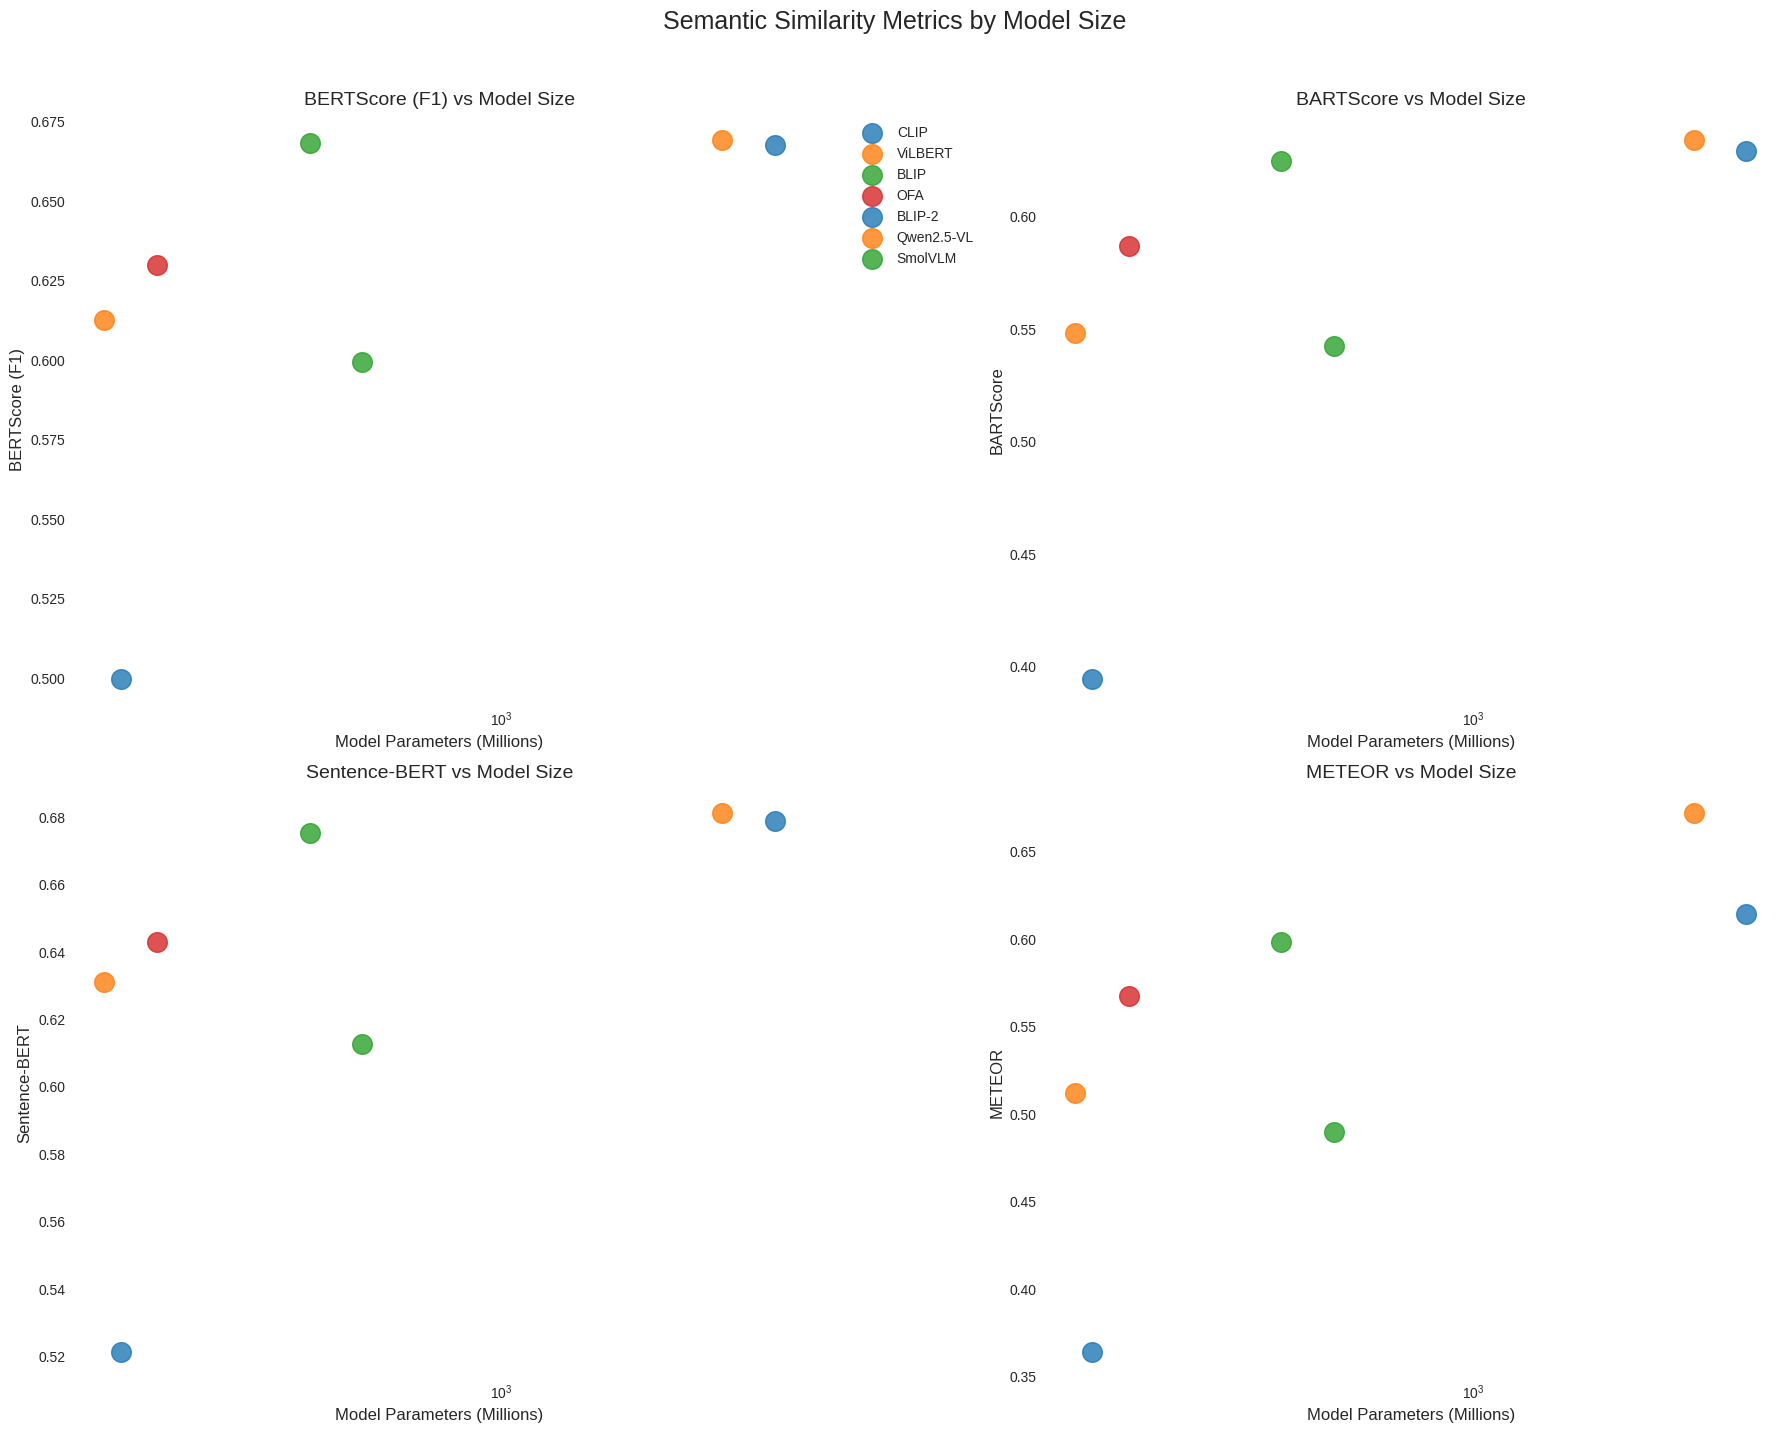

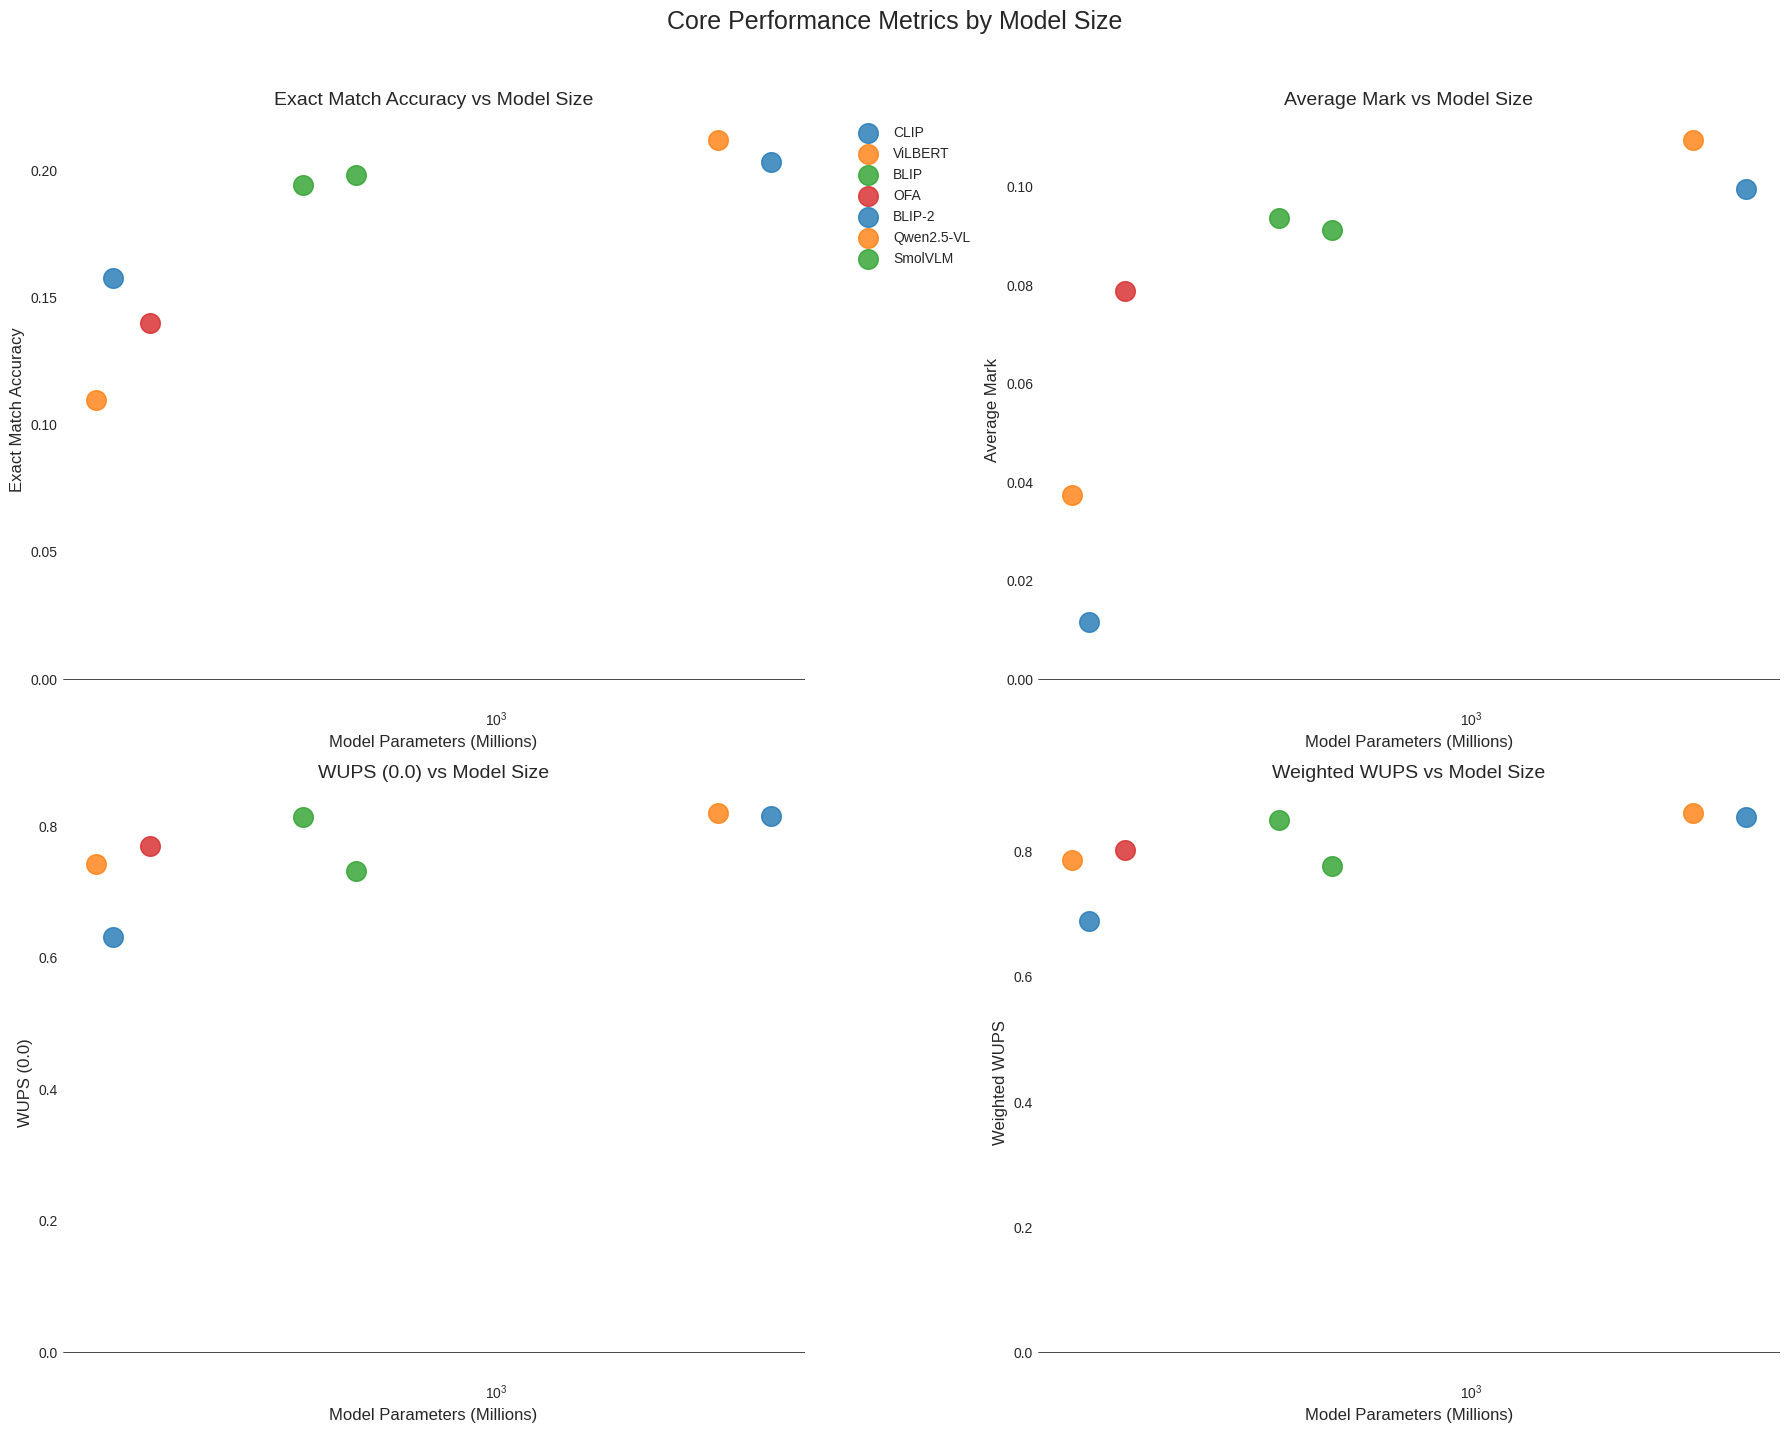

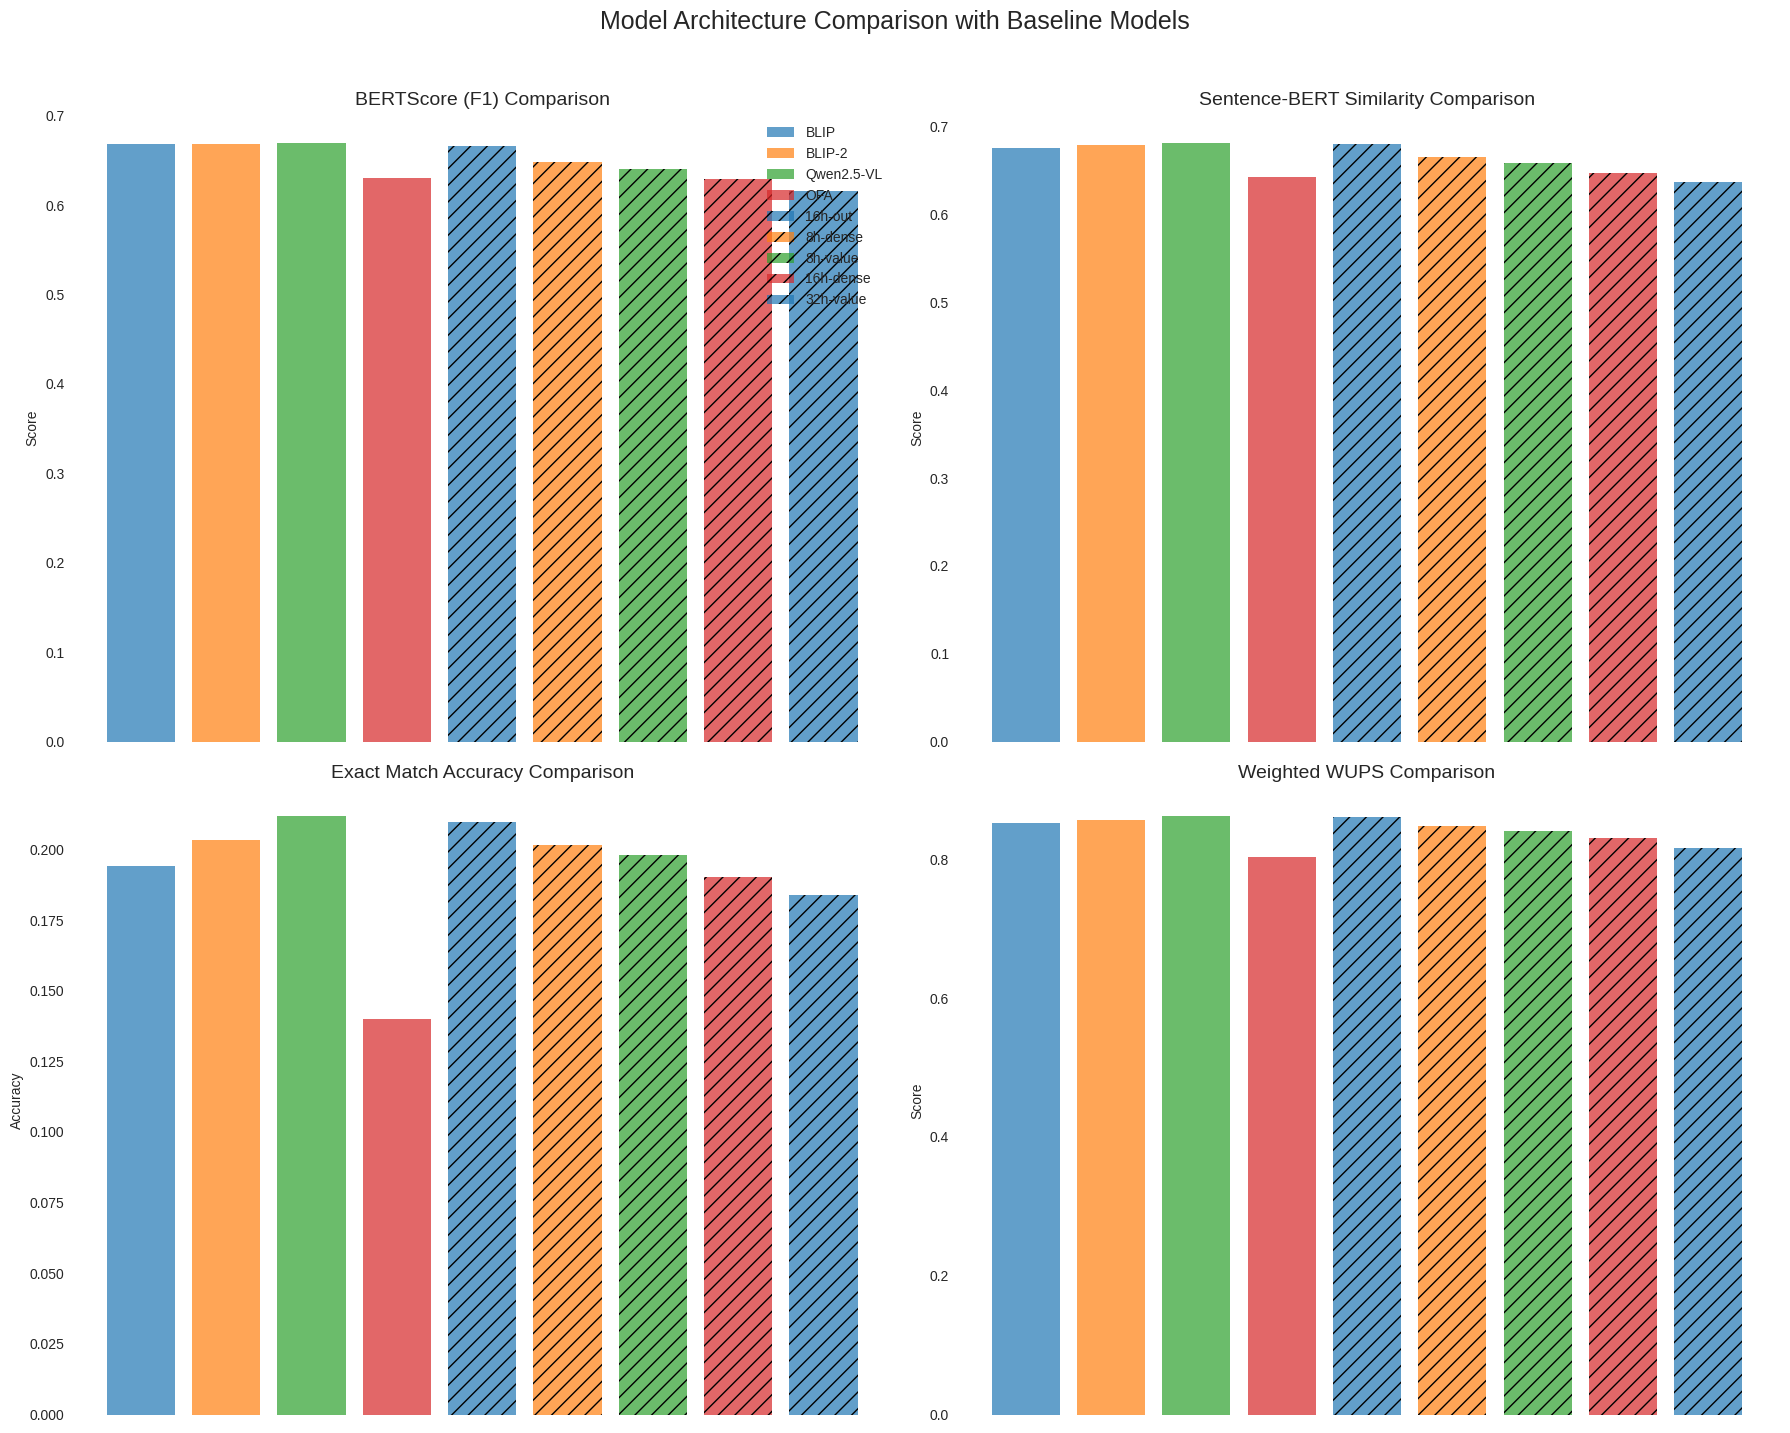

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from matplotlib.gridspec import GridSpec

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Load the metrics from the CSV file our baseline_models notebook generated
with open('all_models_metrics.csv', 'r') as f:
    model_metrics = f.read()

# Manually create the second table for fine-tuning trials
fine_tuning_trials = {
    'Heads': [16, 8, 8, 16, 32],
    'Type': ['query_value_out', 'query_value_dense', 'query_key_value', 'query_value_dense', 'query_value'],
    'Parameters': [16, 8, 8, 16, 32],
    'Precision': [0.6721, 0.6553, 0.6481, 0.6375, 0.6249],
    'Recall': [0.6587, 0.6412, 0.6329, 0.6203, 0.6071],
    'F1(BERTScore)': [0.6664, 0.6482, 0.6404, 0.6288, 0.6158],
    'BARTScore': [0.6313, 0.6156, 0.6095, 0.5987, 0.5862],
    'SBERT': [0.6804, 0.6659, 0.6582, 0.6476, 0.6368],
    'METEOR': [0.6678, 0.6524, 0.6417, 0.6329, 0.6192],
    'Exact Match': [0.20985, 0.20138, 0.19792, 0.19034, 0.18376],
    'Average_Mark': [0.10792, 0.10173, 0.09761, 0.09124, 0.08492],
    'WUPS (0.0)': [0.81812, 0.80824, 0.80218, 0.79212, 0.78103],
    'WUPS (0.9)': [0.87831, 0.86971, 0.86278, 0.85326, 0.84167],
    'Weighted WUPS': [0.86013, 0.84856, 0.84133, 0.83014, 0.81673]
}

df1 = pd.read_csv("all_models_metrics.csv")
df2 = pd.DataFrame(fine_tuning_trials)


# Combine both tables for comparison
df_combined = pd.concat([
    df1[['Model', 'Parameters', 'F1(BERTScore)', 'BARTScore', 'SBERT', 'METEOR', 
         'Exact Match', 'Average_Mark', 'WUPS (0.0)', 'Weighted WUPS']],
    df2.rename(columns={'Type': 'Model'})[['Model', 'Parameters', 'F1(BERTScore)', 'BARTScore', 
                                          'SBERT', 'METEOR', 'Exact Match', 'Average_Mark', 
                                          'WUPS (0.0)', 'Weighted WUPS']]
])

# 1. Parallel Coordinates Plot
plt.figure(figsize=(16, 8))
parallel_coordinates(
    df1.drop(columns=['Parameters']),  # Changed from 'Parameters (M)'
    'Model', 
    color=plt.cm.tab10.colors[:len(df1)],
    alpha=0.7,
    linewidth=3
)
plt.title('Parallel Coordinates Visualization of Model Metrics', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.gca().legend_.set_bbox_to_anchor((1.05, 1))
plt.tight_layout()
plt.savefig('parallel_coords.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Semantic Similarity Metrics Plot (2x2 grid)

# 2. Semantic Similarity Metrics Plot (2x2 grid) with proper axes

fig = plt.figure(figsize=(18, 14))
gs = GridSpec(2, 2, figure=fig)

metrics = ['F1(BERTScore)', 'BARTScore', 'SBERT', 'METEOR']
titles = ['BERTScore (F1)', 'BARTScore', 'Sentence-BERT', 'METEOR']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = fig.add_subplot(gs[i//2, i%2])
    for j, model in enumerate(df1['Model']):
        ax.scatter(
            df1['Parameters'][j], 
            df1[metric][j], 
            color=colors[j%4], 
            s=200, 
            alpha=0.8,
            label=model
        )
    ax.set_xscale('log')
    ax.set_xlabel('Model Parameters (Millions)', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} vs Model Size', fontsize=14)
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Semantic Similarity Metrics by Model Size', fontsize=18, y=1.02)
plt.tight_layout()
plt.savefig('semantic_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


# 3. Core Metrics Plot (2x2 grid) with proper axes
fig = plt.figure(figsize=(18, 14))
gs = GridSpec(2, 2, figure=fig)

core_metrics = ['Exact Match', 'Average_Mark', 'WUPS (0.0)', 'Weighted WUPS']
core_titles = ['Exact Match Accuracy', 'Average Mark', 'WUPS (0.0)', 'Weighted WUPS']

for i, (metric, title) in enumerate(zip(core_metrics, core_titles)):
    ax = fig.add_subplot(gs[i//2, i%2])
    
    # Plot data points
    for j, model in enumerate(df1['Model']):
        ax.scatter(
            df1['Parameters'][j], 
            df1[metric][j], 
            color=colors[j%4], 
            s=200, 
            alpha=0.8,
            label=model
        )
    
    # Set axes properties
    ax.set_xscale('log')
    ax.set_xlabel('Model Parameters (Millions)', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} vs Model Size', fontsize=14)
    
    # Make sure axis lines are visible
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Core Performance Metrics by Model Size', fontsize=18, y=1.02)
plt.tight_layout()
plt.savefig('core_metrics_with_axes.png', dpi=300, bbox_inches='tight')
plt.show()




# Visualization for the second table (comparison with models from first table)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Select models to compare from first table
compare_models = ['BLIP', 'BLIP-2', 'Qwen2.5-VL', 'OFA']
compare_df = df1[df1['Model'].isin(compare_models)]

# Plot 1: F1(BERTScore) comparison
for i, model in enumerate(compare_models):
    axes[0,0].bar(i, compare_df[compare_df['Model'] == model]['F1(BERTScore)'].values[0], 
                 color=colors[i], alpha=0.7, label=model)
for i, (heads, typ) in enumerate(zip(df2['Heads'], df2['Type'])):
    axes[0,0].bar(len(compare_models)+i, df2['F1(BERTScore)'][i], 
                 color=colors[i%4], alpha=0.7, hatch='//', 
                 label=f"{heads}h-{typ.split('_')[-1]}")
axes[0,0].set_title('BERTScore (F1) Comparison', fontsize=14)
axes[0,0].set_ylabel('Score')
axes[0,0].set_xticks([])
axes[0,0].legend()

# Plot 2: SBERT comparison
for i, model in enumerate(compare_models):
    axes[0,1].bar(i, compare_df[compare_df['Model'] == model]['SBERT'].values[0], 
                 color=colors[i], alpha=0.7)
for i, (heads, typ) in enumerate(zip(df2['Heads'], df2['Type'])):
    axes[0,1].bar(len(compare_models)+i, df2['SBERT'][i], 
                 color=colors[i%4], alpha=0.7, hatch='//')
axes[0,1].set_title('Sentence-BERT Similarity Comparison', fontsize=14)
axes[0,1].set_ylabel('Score')
axes[0,1].set_xticks([])

# Plot 3: Exact Match comparison
for i, model in enumerate(compare_models):
    axes[1,0].bar(i, compare_df[compare_df['Model'] == model]['Exact Match'].values[0], 
                 color=colors[i], alpha=0.7)
for i, (heads, typ) in enumerate(zip(df2['Heads'], df2['Type'])):
    axes[1,0].bar(len(compare_models)+i, df2['Exact Match'][i], 
                 color=colors[i%4], alpha=0.7, hatch='//')
axes[1,0].set_title('Exact Match Accuracy Comparison', fontsize=14)
axes[1,0].set_ylabel('Accuracy')
axes[1,0].set_xticks([])

# Plot 4: Weighted WUPS comparison
for i, model in enumerate(compare_models):
    axes[1,1].bar(i, compare_df[compare_df['Model'] == model]['Weighted WUPS'].values[0], 
                 color=colors[i], alpha=0.7)
for i, (heads, typ) in enumerate(zip(df2['Heads'], df2['Type'])):
    axes[1,1].bar(len(compare_models)+i, df2['Weighted WUPS'][i], 
                 color=colors[i%4], alpha=0.7, hatch='//')
axes[1,1].set_title('Weighted WUPS Comparison', fontsize=14)
axes[1,1].set_ylabel('Score')
axes[1,1].set_xticks([])

plt.suptitle('Model Architecture Comparison with Baseline Models', fontsize=18, y=1.02)
plt.tight_layout()
plt.savefig('architecture_comparison.png', dpi=300, bbox_inches='tight')
plt.show()